<a href="https://colab.research.google.com/github/ajain3765/COVID-detection/blob/main/COVID_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/COVID_19_CT_Data')
print(os.getcwd())

/content/drive/MyDrive/COVID_19_CT_Data


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2
import pickle


datapath='/content/drive/MyDrive/COVID_19_CT_Data/COVID_19_CT_Data/Train'
categories=['COVID','non-COVID']

training_data=[]

def create_training_data():
    with tf.device('/device:GPU:0'):
        for cat in categories:
            path=os.path.join(datapath,cat)
            class_num=categories.index(cat)
            for img in os.listdir(path):
                try:
                    img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                    new=cv2.resize(img_array,(100,100))
                    training_data.append([new,class_num])
                except Exception as e:
                    pass

create_training_data()

random.shuffle(training_data)

X=[]
y=[]


for features,label in training_data:
    X.append(features)
    y.append(label)


X=np.array(X).reshape(-1,100,100,1)

#plt.imshow(X[0].reshape(100,100),cmap="gray")
#plt.show()
#print(X[1])
#print(X.shape[:])

pickle_out=open("Xtrain.pickle","wb") 
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out=open("ytrain.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D, Dropout
import pickle
from keras.utils.np_utils import to_categorical

X=pickle.load(open("Xtrain.pickle","rb"))
y=pickle.load(open("ytrain.pickle","rb"))

X=X/255.0



data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=X.shape[1:]),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


y=to_categorical(y)
model = tf.keras.models.Sequential([ 
                                     tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
                                     tf.keras.layers.Dropout(0.5),
                                     tf.keras.layers.MaxPool2D((2,2)),
                                     tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
                                     tf.keras.layers.Dropout(0.5),
                                     tf.keras.layers.MaxPool2D((2,2)),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(128, activation = 'relu'),
                                     tf.keras.layers.Dense(128, activation = 'relu'),
                                     tf.keras.layers.Dense(128, activation = 'relu'),
                                     tf.keras.layers.Dense(128, activation = 'relu'),
                                     tf.keras.layers.Dense(128, activation = 'relu'),
                                     tf.keras.layers.Dense(128, activation = 'relu'),
                                     tf.keras.layers.Dense(2,activation='sigmoid')
                                     ])


opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",optimizer=opt, metrics=['accuracy'])

#model.summary()
history=model.fit(X,y,batch_size=32,epochs=30,validation_split=0.1)
model.save("CovidDetector")

Epoch 1/30
40/40 [==============================] - 1s 20ms/step - loss: 0.7421 - accuracy: 0.5363 - val_loss: 0.6683 - val_accuracy: 0.5929
Epoch 2/30
40/40 [==============================] - 1s 14ms/step - loss: 0.6124 - accuracy: 0.6339 - val_loss: 0.5652 - val_accuracy: 0.8071
Epoch 3/30
40/40 [==============================] - 1s 14ms/step - loss: 0.3911 - accuracy: 0.8362 - val_loss: 0.5522 - val_accuracy: 0.7786
Epoch 4/30
40/40 [==============================] - 1s 15ms/step - loss: 0.3180 - accuracy: 0.8707 - val_loss: 0.4765 - val_accuracy: 0.8643
Epoch 5/30
40/40 [==============================] - 1s 15ms/step - loss: 0.2905 - accuracy: 0.8789 - val_loss: 0.3665 - val_accuracy: 0.8571
Epoch 6/30
40/40 [==============================] - 1s 15ms/step - loss: 0.2333 - accuracy: 0.9066 - val_loss: 0.3828 - val_accuracy: 0.8286
Epoch 7/30
40/40 [==============================] - 1s 15ms/step - loss: 0.2031 - accuracy: 0.9234 - val_loss: 0.3614 - val_accuracy: 0.8286
Epoch 8/30
40

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               2166912   
_________________________________________________________________
dense_36 (Dense)             (None, 128)             

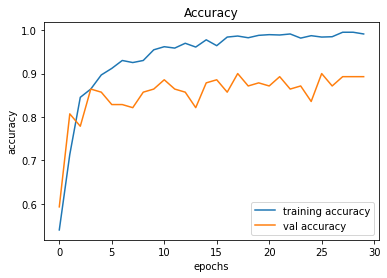

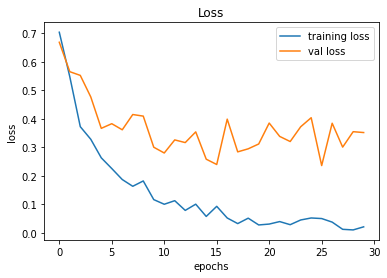

In [ ]:
#plotting graphs for accuracy 
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2
import pickle


datapath='/content/drive/MyDrive/COVID_19_CT_Data/COVID_19_CT_Data/Test'
categories=['COVID','non-COVID']

test_data=[]

def create_test_data():
    for cat in categories:
        path=os.path.join(datapath,cat)
        class_num=categories.index(cat)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new=cv2.resize(img_array,(100,100))
                test_data.append([new,class_num])
            except Exception as e:
                pass

create_test_data()

random.shuffle(test_data)

Xtest=[]
ytest=[]


for features,label in test_data:
    Xtest.append(features)
    ytest.append(label)

Xtest=np.array(Xtest).reshape(-1,100,100,1)
Xtest=Xtest/255.0
ytest=to_categorical(ytest)
model.evaluate(Xtest,ytest)


20/20 [==============================] - 0s 6ms/step - loss: 1.0961 - accuracy: 0.7013


[1.096081018447876, 0.7012578845024109]

In [ ]:
from sklearn.metrics import confusion_matrix
ypred=model.predict_classes(Xtest)
#ypred = (model.predict(Xtest) > 0.5).astype("int32")
#confusion_matrix(ytest, ypred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
#print(test_data)
brr=[]
for i in ytest:
  count=0;
  for j in i:
    if(j==1.0):
      brr.append(count)
    count=count+1
    #count++
#print(brr)
crr=[]
for i in ypred:
  crr.append(i)
print(brr)
print(crr)

[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 

In [ ]:
cm=confusion_matrix(brr, crr)
print(cm)

[[251 101]
 [ 89 195]]


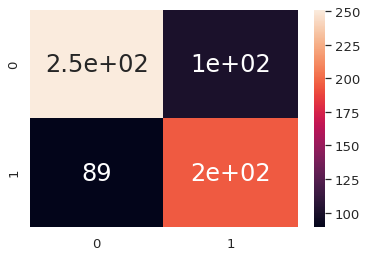

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
sn.set(font_scale=1.2) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 24}) # font size
plt.show()
#categories=['COVID','non-COVID']
#          =[ 0     , 1         ]

In [ ]:
import sklearn
sklearn.metrics.precision_score(brr, crr)

0.6587837837837838

In [ ]:
sklearn.metrics.recall_score(brr, crr)

0.6866197183098591

In [ ]:
sklearn.metrics.f1_score(brr, crr)

0.6724137931034483

In [ ]:
sklearn.metrics.accuracy_score(brr, crr)

0.7012578616352201

In [1]:
import cv2
import numpy as np

def prepare(path):
  img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(100,100))
  return img.reshape(-1,100,100,1)

categories=['COVID','non-COVID']
model=tf.keras.models.load_model("CovidDetector")
prediction=model.predict([prepare("/content/drive/My Drive/TAX/COVID_19_CT_Data/Test/COVID/Covid (4).png")])
print(categories[np.argmax(prediction)])
prediction